In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import torch
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_selection import RFECV
import xgboost as xgb
import lightgbm as lgbm
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_validate
from ray import tune
from concurrent.futures import ThreadPoolExecutor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import importlib
import all_merics
importlib.reload(all_merics)
from all_merics import *
import mlp_model
importlib.reload(mlp_model)
from mlp_model import *

In [2]:
df_train_proba = pd.read_csv('results/X_train_proba_0107.csv', index_col=0)
df_test_proba= pd.read_csv('results/X_test_proba_0107.csv', index_col=0)

In [4]:
def featurelabels(opt, df_train=df_train_proba, df_test=df_test_proba):

    X_train, X_test, y_train, y_test = df_train[opt], df_test[opt], df_train['label'], df_test['label'],

    X_train = torch.tensor(X_train.values).to(torch.float32)
    X_test = torch.tensor(X_test.values).to(torch.float32)
    y_train = torch.LongTensor(y_train.values)
    y_test = torch.LongTensor(y_test.values)
    return X_train, X_test, y_train, y_test

gapen_descri_list = [['xgb_gapen', 'xgb_descri'], ['lgbm_gapen', 'lgbm_descri']]
gapen_descri_namelist = ['xgb_all', 'lgbm_all']

In [5]:
def train_lr(config,data):
    X_train, y_train = data[0], data[1]
    C = config['C']
    clf = LR(C=C,penalty='l1',solver='liblinear', class_weight='balanced',random_state=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=1) #balanced_accuracy
    tune.report(balanced_accuracy=scores.mean())

def train_exotox(datastr,train_clf,test_clf,config_clf, num_samples = 64, ):
    X_train, X_test, y_train, y_test = featurelabels(datastr)
    analysis = tune.run(
        tune.with_parameters(train_clf, data = (X_train, y_train)),
        resources_per_trial={'cpu': 2, },
        num_samples=num_samples,
        config = config_clf,
        metric='balanced_accuracy',
        mode='max',
        verbose=0,
    )
    best_trial = analysis.get_best_trial("balanced_accuracy", "max")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation ba: {}".format(best_trial.last_result["balanced_accuracy"]))
    print(f"Loss results: {analysis}")

    scores_test = test_clf(best_trial.config, X_train, X_test, y_train, y_test)
    return scores_test, best_trial.config

def train_split_data(train_clf, config_clf, test_clf, gapen_descri_list = gapen_descri_list, ):
    all_scores_test = []
    all_configs = []
    for data_str in gapen_descri_list:
        scores_test, config = train_exotox(data_str,train_clf,test_clf,config_clf )
        all_scores_test.append(scores_test)
        all_configs.append(config)
    return all_scores_test, all_configs

config_lr = {
            'C' : tune.loguniform(1e-3, 1e-1),
        }

In [ ]:
all_scores_test_LR , all_configs_LR= train_split_data(train_lr,config_lr,test_lr )


In [6]:
X_train, X_test, y_train, y_test = featurelabels(gapen_descri_list[0])
xgb_scores_test_LR = final_test_lr({'C':0.074667},'XGB_LR', X_train, X_test, y_train, y_test)

{'test_acc': 0.9165813715455476, 'test_ba': 0.9088410735957004, 'test_f1': 0.8486536675951717, 'test_auc': 0.9647861856362691, 'test_mcc': 0.7930978628962196, 'test_sn': 0.892578125, 'test_sp': 0.9251040221914009}


In [46]:
X_train, X_test, y_train, y_test = featurelabels(gapen_descri_list[0])
xgb_scores_test_LR = final_test_lr({'C':0.074667},'XGB_LR', X_train, X_test, y_train, y_test)


{'test_acc': 0.9165813715455476, 'test_ba': 0.9088410735957004, 'test_f1': 0.8486536675951717, 'test_auc': 0.9647861856362691, 'test_mcc': 0.7930978628962196, 'test_sn': 0.892578125, 'test_sp': 0.9251040221914009}


In [8]:
X_train, X_test, y_train, y_test = featurelabels(gapen_descri_list[1])
lgbm_scores_test_LR = final_test_lr({'C':0.005211},'LGBM_LR', X_train, X_test, y_train, y_test)

{'test_acc': 0.9042988741044012, 'test_ba': 0.9030385857316228, 'test_f1': 0.8313796212804327, 'test_auc': 0.9641753261529127, 'test_mcc': 0.7695150944331152, 'test_sn': 0.900390625, 'test_sp': 0.9056865464632455}


In [47]:
X_train, X_test, y_train, y_test = featurelabels(gapen_descri_list[1])
lgbm_scores_test_LR = final_test_lr({'C':0.005211},'LGBM_LR', X_train, X_test, y_train, y_test)

{'test_acc': 0.9042988741044012, 'test_ba': 0.9030385857316228, 'test_f1': 0.8313796212804327, 'test_auc': 0.9641753261529127, 'test_mcc': 0.7695150944331152, 'test_sn': 0.900390625, 'test_sp': 0.9056865464632455}


In [48]:
df_all_LR = pd.DataFrame([xgb_scores_test_LR,lgbm_scores_test_LR],index = gapen_descri_namelist)
df_all_LR.to_csv('results/LR_finalproba_0107.csv')
df_config_LR = pd.DataFrame([{'C':0.074667}, {'C':0.005211}],index = gapen_descri_namelist)
df_config_LR.to_csv('results/LR_config_finalproba_0107.csv')
print(df_all_LR) #0.074667
print(df_config_LR) 

          test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn   test_sp
xgb_all   0.916581  0.908841  0.848654  0.964786  0.793098  0.892578  0.925104
lgbm_all  0.904299  0.903039  0.831380  0.964175  0.769515  0.900391  0.905687
                 C
xgb_all   0.074667
lgbm_all  0.005211


{'test_acc': 0.9165813715455476, 'test_ba': 0.9088410735957004, 'test_f1': 0.8486536675951717, 'test_auc': 0.9647861856362691, 'test_mcc': 0.7930978628962196, 'test_sn': 0.892578125, 'test_sp': 0.9251040221914009}


TypeError: __init__() got an unexpected keyword argument 'fontdict'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


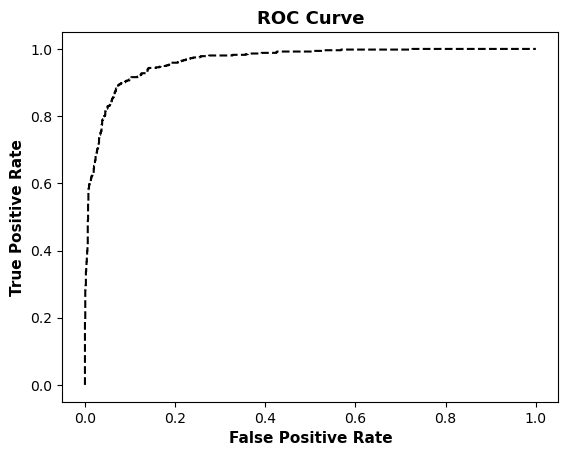

In [7]:
#加载模型
def pickle_model_test(clf_str,  datastr):
    X_train, X_test, y_train, y_test = featurelabels(datastr)
    with open('models/'+clf_str+'.pkl', 'rb') as f:
        clf = pickle.load(f)
    # test_all_proba = clf.predict_proba(X_test)
    # test_all_proba = np.array(test_all_proba[:,1]).flatten()
    y_test_pred = clf.predict(X_test)
    y_test_probas = clf.predict_proba(X_test)
    y_test_probas = y_test_probas[:, 1]
    acc = metrics.accuracy_score(y_test, y_test_pred)
    ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_probas)
    mcc, sn, sp = all_scores(y_test,y_test_pred)
    scores = {'test_acc':acc, 'test_ba':ba, 'test_f1':f1, 'test_auc':auc,
              'test_mcc':mcc, 'test_sn':sn, 'test_sp':sp}
    print(scores)
    return y_test_probas

lr_xgb_test = pickle_model_test('XGB_LR', gapen_descri_list[0])

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

font= {'family' : 'Times New Roman','fontsize': 13, 'fontweight': 'bold',}
font2= {'family' : 'Times New Roman', 'fontsize': 11, 'fontweight': 'bold'}

y_test = df_test_proba['label']
fpr, tpr, thersholds = roc_curve(y_test, lr_xgb_test)
roc_auc = auc(fpr, tpr)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.6f})'.format(roc_auc) )
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontdict=font2)
plt.ylabel('True Positive Rate', fontdict=font2)
plt.title('ROC Curve', fontdict=font )
plt.legend(loc="lower right", fontdict=font2)
plt.show()